# Multistage semibatch reactor model in Python

The model is composed of 3 polysubstitution reactions which are simultaneously in parallel and in series,

$$ \ce{A + B ->[k_{1}] R} \ , $$
$$ \ce{R + B ->[k_{2}] S} \ , $$
$$ \ce{S + B ->[k_{3}] T} \ . $$

All three reactions are assumed to be exothermic, i.e., $\Delta H_{reaction,i} < 0$, for $\forall i \in \{ 1,2,3 \}$, meaning that the reactions release heat. In order to prevent the temperature from rising, a temperature control mechanism has to be implemented.

A schematic representation of the semibatch reactor is shown below. The reactor is assumed to be a perfectly stirred tank, meaning that there are no concentration and temperature gradients spatially ($\frac{\partial C_{i}}{\partial x} = 0$, where x can be any of the 3 dimensional Cartesian coordinates). Instead, these state variables vary over time according to the system dynamics of the model. Chill water is circulated through a cooling jacket to control the reactor temperature. Hence, the control variable is the cooling water flow-rate $q_{c} (t)$, while the controlled variable is the reactor temperature $T(t)$. In order to avoid a thermal runaway, reactant B is added semi-continuously, so as to keep reaction rates limited.

<p align="center">
    <img src = Semibatch_reactor.png width = "500" height = "500" >
</p>

The model is composed of a system of Ordinary Differential Equations consisting of the material and energy balances of the process. The generic material balances for all the reactants, intermediates and products are 

$$ \frac{d C_{A}}{d t}=-k_{0,1} \exp \left(\frac{-E_{A,1}}{R T}\right) C_{A} C_{B} -\frac{q_{in}}{V} C_{A} \ , $$
$$ \frac{d C_{B}}{d t}=-k_{0,1} \exp \left(\frac{-E_{A,1}}{R T}\right) C_{A} C_{B} -k_{0,2} \exp \left(\frac{-E_{A,2}}{R T}\right)C_{R}C_{B} - ... $$
$$ ... -k_{0,3} \exp \left(\frac{-E_{A,3}}{R T}\right) C_{S} C_{B} -\frac{q_{in}}{V} \left(C_{B}-C_{B,in}\right) \ , $$
$$ \frac{d C_{R}}{d t}= k_{0,1} \exp \left(\frac{-E_{A,1}}{R T}\right) C_{A} C_{B} -k_{0,2} \exp \left(\frac{-E_{A,2}}{R T}\right)C_{R}C_{B} -\frac{q_{in}}{V} C_{R} \ , $$
$$ \frac{d C_{S}}{d t}= k_{0,2} \exp \left(\frac{-E_{A,2}}{R T}\right)C_{R}C_{B} -k_{0,3} \exp \left(\frac{-E_{A,3}}{R T}\right) C_{S} C_{B} -\frac{q_{in}}{V} C_{S} \ , $$
$$ \frac{d C_{T}}{d t}= k_{0,3} \exp \left(\frac{-E_{A,3}}{R T}\right) C_{S} C_{B} -\frac{q_{in}}{V} C_{T} \ . $$

The heat balances over the reactor ($T(t)$) and over the cooling jacket ($T_c (t)$), which provide the temperature dynamics of each component.

$$ \frac{d T}{d t} = \frac{q_{in}}{V} \left(T_{in}-T\right) + \left(-\Delta H_{R,1}\right) k_{0,1} \exp \left(\frac{-E_{A,1}}{R T}\right) C_{A} C_{B} + ... $$
$$ ... + \left(-\Delta H_{R,2}\right) k_{0,2} \exp \left(\frac{-E_{A,2}}{R T}\right) C_{R} C_{B} + \left(-\Delta H_{R,3}\right) k_{0,3} \exp \left(\frac{-E_{A,3}}{R T}\right) C_{S} C_{B} + ... $$
$$ ... + \frac{q_{c} \rho_{c} C_{p,c}}{\rho C_{p} V}\left(T_{c,feed }-T_{c}\right)\left[1-\exp \left(-\frac{UA}{q_{c} \rho_{c} C_{p,c}}\right)\right] + \frac{W_{shaft}}{\rho C_{p} V} \ , $$

$$ \frac{d T_{c}}{d t} = \frac{q_{c}}{V_{c}}\left(T_{c,feed}-T_{c}\right)-\frac{q_{c} \rho_{c} C_{p,c}}{\rho C_{p} V}\left(T_{c,feed}-T \right) \left[1-\exp \left(-\frac{UA}{q_{c} \rho_{c} C_{p,c}}\right)\right] \ . $$

Multiple stages were defined based on modification of the heat and material balances. The following stages were considered:

1. *Solvent loading*: the reactor is filled with solvent up to a volume $V_{0} = 2 \ m^{3}$.
2. *Reactant loading*: reactants are are added up to a concentration of $C_{A,0} = 1500\ mol\ m^{-3}, C_{B,0} = 500\ mol\ m^{-3}$.
3. *Heating*: the reactor temperature is raised up to 300 $^{o}C$ with an electrical wire according to the Joule-Lenz law.
4. *Reaction*: semibatch reaction with feed $q_{in} = 0.0002 \ m^{3}s^{-1}$ until a 90 \% conversion of A is achieved, i.e., $C_{A} = 0.1 \cdot C_{A,0}$. The PID controller is active throughout the duration of the reaction stage.
5. *Cooling*: the cooling water flow rate is raised to the maximum allowed by the pump ($q_{max}$) until the temperature is reduced to $T = 50 ^{o}C$.
6. *Unloading*: a valve is opened to extract the reactor contents until there is no volume left inside of the tank.

It was assumed that the reaction requires no initiator, and only depends on the temperature according to the Arrhenius equation. Hence, the reaction will start to occur in the latter part of the heating stage, mainly on the reaction stage, and to some extent on the cooling stage.

*Note*: all the parameters and reaction kinetics do not correspond to any real reaction, they were all made up for this example.

### Import packages

In [3]:
from typing import Optional
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True  # write label & legend in LaTex
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy import integrate
from scipy import signal
import seaborn as sns
from datetime import datetime
sns.set_context('talk',font_scale=1.5,rc={"lines.linewidth": 3})

### Define parameter values

In [4]:
# Reactions kinetics
Ea_mono  = 88000     # activation energy [J/mol]
k0_mono  = 128.5   # Arrhenius rate constant [m3/(mol·s)]
dHr_mono = -97200    # Enthalpy of reaction [J/mol]

Ea_di  = 87800     # activation energy [J/mol]
k0_di  = 17.5   # Arrhenius rate constant [m3/(mol·s)]
dHr_di = -86200    # Enthalpy of reaction [J/mol]

Ea_tri  = 88900     # activation energy [J/mol]
k0_tri  = 10.5   # Arrhenius rate constant [m3/(mol·s)]
dHr_tri = -75200    # Enthalpy of reaction [J/mol]


# Constants and parameters
R   = 8.314     # gas constant [J/(mol·K)]
g = 9.81      # gravity constant [m/s2]
rho = 1000.0    # Density [kg/m3]  --> liquid state reaction: assume rho is constant
Cp  = 1350     # Heat capacity [J/(kg·K)]
UA  = 1250     # Heat transfer coefficient [W/K]
intensity = 50  # current intensity of the heating wire [Ampere]
voltage = 350   # voltage differential accros the heating wire [Volt]
W_shaft = 0  # Shaft power of impller [W] --> assume that the energy introduced by the stirring is negligible compared to the other terms


# Semibatch additions
q_feed = 0.0001  # volumetric flow rate of feeding during semibatch stages [m3/s]
Cb_feed = 2000  # concentration of feed added during semibatch stages [mol/3]
T_feed = 360 + 273  # temperature of the feed during the semibatch stages [K]


# Cooling water
Tcf = 15.0 + 273    # Coolant feed temperature [K]
Cp_water = 4184  # Heat capacity of cooling water [J/(kg·K)]
Vc = 0.1       # Cooling jacket volume [m3]
qc_hat = 0.000035  # Average operating point for the cooling water flow-rate

### Define the initial conditions

In [5]:
# Initial concentrations [mol/m3]
Ca0 = 1500
Cb0 = 500
Cr0 = 0
Cs0 = 0
Ct0 = 0

# Initial conditions
V0   = 2     # Volume [m3]
T0  = 25.0 + 273   # Initial temperature [K]
mu0 = 1    # viscosity of the solution when Ca = Cb = Cr = Cs = Ct = 0 [Pa·s]

### Define additional functions

In [6]:
### Define required functions

# Control saturation --> anti windup
qc_min = 0.0000001                   # minimum possible coolant flowrate
qc_max = 0.2
                         # maximum possible coolant flowrate
def sat(qc):                         # function to return feasible value of qc
    return np.clip(qc, qc_min, qc_max)


# Define the terminal events to switch between stages

def Cb_left_60(t,y):    # terminal event when Cb = 60 mol/m3
    return y[1] - 60
Cb_left_60.terminal = True

def conversionA_90(t,y):    # terminal event Ca = 0.02*Ca0 (98% conversion for A)
    return y[0] - 0.1*Ca0
conversionA_90.terminal = True

def volume500(t,y):    # terminal event with volume increase of 0.5 m3
    volume500 = y[8] - V_sim[-1][-1] - 0.5
    return volume500
volume500.terminal = True


### Define the model for each stage 

An Object Oriented Programming (OOP) approach was taken, where each stage was defined as a class, and the set of Ordinary Differential Equations (ODEs) describing the stage were defined with a method within the class. Beware that every stage had its own set of ODEs that were derived according to the specifics of the stage based on the general ODE system. For every stage, an object instance was created from the respective class, and the simulation was performed by running the corresponding method. Hence, each stage was solved for independently, and the initial conditions of each stage were taken as the final conditions of the previous stage. This modular approach can also be easily extended to add other stages to the model.

In [7]:
### Define the batch reactor model with a PID --> modular approach: add stage using a new class (easier to add new stages)

class BatchUnLoading:  # create an instance of the parent class to define each stage

    """STAGE 0:
    - Load method -
    Load the content of the reactor.
    First the volume is filled with solvent, and then the reactants are added (e.g. in powder form; assume volume remains constant).

    - Unload method -
    Unload the content of the batch (V goes to 0; mixture homogeneous so concentrations remain constant)
    """

    def __init__(self,
                Ca:float, Cb:float, Cr:float, Cs: float, Ct:float,
                T:float, Tc:float, V:float):   # Add the attributes and their initial states

        self.__Ca = Ca
        self.__Cb = Cb
        self.__Cr = Cr
        self.__Cs = Cs
        self.__Ct = Ct

        self.__T = T
        self.__Tc = Tc
        self.__E = 0
        self.__V = V

    def load_solvent(self, t_span, t_eval):      # This method computes the state variables after time `dt` starting from its current state by solving an IVP

        def solvent_addition_model(t, state_variables):
            Ca  = state_variables[0]  # concentration of the reactant [mol/m3]
            Cb = state_variables[1]  # concentration of the second reactant [mol/m3]
            Cr = state_variables[2]  # concentration of the monosubstituted product [mol/m3]
            Cs = state_variables[3]  # concentration of the disubstituted product [mol/m3]
            Ct = state_variables[4]  # concentration of the trisubstituted product [mol/m3]
            T  = state_variables[5]  # temperature of the reactor [ºC]
            Tc = state_variables[6]  # temperature of the cooling jacket [ºC]
            E  = state_variables[7]  # integral of the controller error [ºC·s]
            V = state_variables[8]  # liquid holdup volume in the reactor [m3]

            qc = 0
            dCa = 0
            dCb = 0
            dCr = 0
            dCs = 0
            dCt = 0
            dT = 0
            dTc = 0
            dE = 0
            dV = q_feed*3

            return np.array([dCa,dCb,dCr,dCs,dCt,dT,dTc,dE,dV])

        def solvent_loaded(t,y):    # reactor reaches a volume of V0
            return y[8] - V0
        solvent_loaded.terminal = True

        sol = solve_ivp(solvent_addition_model,
                        t_span,
                        [self.__Ca, self.__Cb, self.__Cr, self.__Cs, self.__Ct, self.__T, self.__Tc, self.__E, self.__V],
                        method ='Radau',
                        t_eval = t_eval,
                        dense_output = True,
                        events = solvent_loaded)

        # Save the results
        t_sim.append(sol.t)
        Ca_sim.append(sol.y[0])
        Cb_sim.append(sol.y[1])
        Cr_sim.append(sol.y[2])
        Cs_sim.append(sol.y[3])
        Ct_sim.append(sol.y[4])
        T_sim.append(sol.y[5])
        Tc_sim.append(sol.y[6])
        E_sim.append(sol.y[7])
        V_sim.append(sol.y[8])
        for i in range(len(t_sim[-1])): qc_sim.append(0), stages_sim.append(0), T_setpoint_sim.append(0+273)

    def load_reactants(self, t_span, t_eval):      # This method computes the state variables after time `dt` starting from its current state by solving an IVP

        def reactant_addition_model(t, state_variables):
            Ca  = state_variables[0]  # concentration of the reactant [mol/m3]
            Cb = state_variables[1]  # concentration of the second reactant [mol/m3]
            Cr = state_variables[2]  # concentration of the monosubstituted product [mol/m3]
            Cs = state_variables[3]  # concentration of the disubstituted product [mol/m3]
            Ct = state_variables[4]  # concentration of the disubstituted product [mol/m3]
            T  = state_variables[5]  # temperature of the reactor [ºC]
            Tc = state_variables[6]  # temperature of the cooling jacket [ºC]
            E  = state_variables[7]  # integral of the controller error [ºC·s]
            V = state_variables[8]  # volume of the content in the reactor [m3]

            # Ca is added at 1.5 mol/m3·s while Cb is added at 0.5 mol/m3·s
            qc = qc_min
            dCa = 1.5 - k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb
            dCb = 0.5 - k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb
            dCr = k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb - k0_di*np.exp(-Ea_di/R/T)*Cr*Cb
            dCs = k0_di*np.exp(-Ea_di/R/T)*Cr*Cb - k0_tri*np.exp(-Ea_tri/R/T)*Cs*Cb
            dCt = k0_tri*np.exp(-Ea_tri/R/T)*Cs*Cb
            dT = (-dHr_mono/rho/Cp)*k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb + (-dHr_di/rho/Cp)*k0_di*np.exp(-Ea_di/R/T)*Cr*Cb + (-dHr_tri/rho/Cp)*k0_tri*np.exp(-Ea_tri/R/T)*Cs*Cb + (UA/V/rho/Cp)*(Tc - T)
            dTc = (qc/Vc)*(Tcf - Tc) + (UA/V/rho/Cp)*(T - Tc)
            dE = 0
            dV = 0

            return np.array([dCa,dCb,dCr,dCs,dCt,dT,dTc,dE,dV])

        def reactantA_loaded(t,y):    # reactor with Ca = Ca0
            return y[0] - Ca0
        reactantA_loaded.terminal = True

        sol = solve_ivp(reactant_addition_model,
                        t_span,
                        [self.__Ca, self.__Cb, self.__Cr, self.__Cs, self.__Ct, self.__T, self.__Tc, self.__E, self.__V],
                        method ='Radau',
                        t_eval = t_eval,
                        dense_output = True,
                        events = reactantA_loaded)

        # Save the results
        t_sim.append(sol.t[1:])
        Ca_sim.append(sol.y[0][1:])
        Cb_sim.append(sol.y[1][1:])
        Cr_sim.append(sol.y[2][1:])
        Cs_sim.append(sol.y[3][1:])
        Ct_sim.append(sol.y[4][1:])
        T_sim.append(sol.y[5][1:])
        Tc_sim.append(sol.y[6][1:])
        E_sim.append(sol.y[7][1:])
        V_sim.append(sol.y[8][1:])
        for i in range(len(t_sim[-1])): qc_sim.append(0), stages_sim.append(0), T_setpoint_sim.append(0+273)

    def unload(self, t_span, t_eval):      # This method computes the state variables after time `dt` starting from its current state by solving an IVP

        def reactant_addition_model(t, state_variables):
            Ca  = state_variables[0]  # concentration of the reactant [mol/m3]
            Cb = state_variables[1]  # concentration of the second reactant [mol/m3]
            Cr = state_variables[2]  # concentration of the monosubstituted product [mol/m3]
            Cs = state_variables[3]  # concentration of the disubstituted product [mol/m3]
            Ct = state_variables[4]  # concentration of the disubstituted product [mol/m3]
            T  = state_variables[5]  # temperature of the reactor [ºC]
            Tc = state_variables[6]  # temperature of the cooling jacket [ºC]
            E  = state_variables[7]  # integral of the controller error [ºC·s]
            V = state_variables[8]  # volume of the content in the reactor [m3]

            qc = 0
            dCa = 0
            dCb = 0
            dCr = 0
            dCs = 0
            dCt = 0
            dT = 0
            dTc = 0
            dE = 0
            dV = -0.001

            return np.array([dCa,dCb,dCr,dCs,dCt,dT,dTc,dE,dV])

        def batch_unloaded(t,y):    # reactor reaches a V of 0
            return y[8]
        batch_unloaded.terminal = True  # When this condition is met the unloading stage will stop

        sol = solve_ivp(reactant_addition_model,
                        t_span,
                        [self.__Ca, self.__Cb, self.__Cr, self.__Cs, self.__Ct, self.__T, self.__Tc, self.__E, self.__V],
                        method ='Radau',
                        t_eval = t_eval,
                        dense_output = True,
                        events = batch_unloaded)

        # Save the results
        t_sim.append(sol.t[1:])
        Ca_sim.append(sol.y[0][1:])
        Cb_sim.append(sol.y[1][1:])
        Cr_sim.append(sol.y[2][1:])
        Cs_sim.append(sol.y[3][1:])
        Ct_sim.append(sol.y[4][1:])
        T_sim.append(sol.y[5][1:])
        Tc_sim.append(sol.y[6][1:])
        E_sim.append(sol.y[7][1:])
        V_sim.append(sol.y[8][1:])
        for i in range(len(t_sim[-1])): qc_sim.append(0), stages_sim.append(6), T_setpoint_sim.append(50+273)


class BatchHeating:  # create an instance of the parent class to define each stage

    """STAGE 1: heating of tank to reaction temperature with an electrical wire --> Joule-Lenz law.
    Assume there are 8 wires for heating.
    When T = T_setpoint, initiator is added and the reaction starts.
    Assume no cooling water flow rate. """

    def __init__(self,
                Ca:float, Cb:float, Cr:float, Cs: float, Ct:float,
                T:float, Tc:float, V:float):   # Add the attributes and their initial states

        self.__Ca = Ca
        self.__Cb = Cb
        self.__Cr = Cr
        self.__Cs = Cs
        self.__Ct = Ct

        self.__T = T
        self.__Tc = Tc
        self.__E = 0
        self.__V = V

    def heat(self, t_span, t_eval):      # This method computes the state variables after time `dt` starting from its current state by solving an IVP

        def batch_heating_model(t, state_variables):
            Ca  = state_variables[0]  # concentration of the reactant [mol/m3]
            Cb = state_variables[1]  # concentration of the second reactant [mol/m3]
            Cr = state_variables[2]  # concentration of the monosubstituted product [mol/m3]
            Cs = state_variables[3]  # concentration of the disubstituted product [mol/m3]
            Ct = state_variables[4]  # concentration of the disubstituted product [mol/m3]
            T  = state_variables[5]  # temperature of the reactor [ºC]
            Tc = state_variables[6]  # temperature of the cooling jacket [ºC]
            E  = state_variables[7]  # integral of the controller error [ºC·s]
            V = state_variables[8]  # volume of the content in the reactor [m3]

            qc = qc_min
            power = 8 * intensity * voltage    # J/s
            dCa = - k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb
            dCb = - k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb
            dCr = k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb - k0_di*np.exp(-Ea_di/R/T)*Cr*Cb
            dCs = k0_di*np.exp(-Ea_di/R/T)*Cr*Cb - k0_tri*np.exp(-Ea_tri/R/T)*Cs*Cb
            dCt = k0_tri*np.exp(-Ea_tri/R/T)*Cs*Cb
            dT = power/(Cp*rho*V) + (-dHr_mono/rho/Cp)*k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb + (-dHr_di/rho/Cp)*k0_di*np.exp(-Ea_di/R/T)*Cr*Cb + (-dHr_tri/rho/Cp)*k0_tri*np.exp(-Ea_tri/R/T)*Cs*Cb + (UA/V/rho/Cp)*(Tc - T)
            dTc = (qc/Vc)*(Tcf - Tc) + (UA/V/rho/Cp)*(T - Tc)
            dE = 0
            dV = 0

            return np.array([dCa,dCb,dCr,dCs,dCt,dT,dTc,dE,dV])

        T_setpoint = 300 + 273
        def batch_heated(t,y):    # reactor reaches a temperature of T_setpoint after heating
            T_setpoint_reached = T_setpoint - y[5]
            return T_setpoint_reached
        batch_heated.terminal = True

        sol = solve_ivp(batch_heating_model,
                        t_span,
                        [self.__Ca, self.__Cb, self.__Cr, self.__Cs, self.__Ct, self.__T, self.__Tc, self.__E, self.__V],
                        method ='Radau',
                        t_eval = t_eval,
                        dense_output = True,
                        events = batch_heated)

        # Save the results
        t_sim.append(sol.t[1:])
        Ca_sim.append(sol.y[0][1:])
        Cb_sim.append(sol.y[1][1:])
        Cr_sim.append(sol.y[2][1:])
        Cs_sim.append(sol.y[3][1:])
        Ct_sim.append(sol.y[4][1:])
        T_sim.append(sol.y[5][1:])
        Tc_sim.append(sol.y[6][1:])
        E_sim.append(sol.y[7][1:])
        V_sim.append(sol.y[8][1:])
        for i in range(len(t_sim[-1])): qc_sim.append(0), stages_sim.append(1), T_setpoint_sim.append(T_setpoint)

class SemiBatchReaction:  # create an instance of the parent class to define each stage

    """STAGE 2: semi-batch reactions in series.
    If q_in = 0, then operation is in batch; if q_in != 0, then it is a semibatch operation (additional reactant B is being added).

    :param Cx: concentration of X (mol/m3)
    :param T: tempertuare of the reactor (K)
    :param Tc: temperature of the cooling water in the jacket at the outlet (K)
    :param E: integral error of the controller (K·s)
    :param V: volume of the reaction mixture (m3)

    :return: lists with the varaible trajectories for Ca, Cb, Cr, Cs, Ct, T, Tc, E, V; input (control) variable qc, and stage = 'reaction'
     """

    def __init__(self,
                Ca:float, Cb:float, Cr:float, Cs:float, Ct:float,
                T:float, Tc:float, V:float, E:float,
                kp: float, ki: float, kd: float):   # Add the attributes and their initial states

        self.__Ca = Ca
        self.__Cb = Cb
        self.__Cr = Cr
        self.__Cs = Cs
        self.__Ct = Ct

        self.__T = T
        self.__Tc = Tc
        self.__E = E
        self.__V = V

        self.__kp = kp
        self.__ki = ki
        self.__kd = kd

    def _qc(self, T_setpoint, T, Tc, Ca, Cb, Cr, Cs, E, V):        # Add a PID controller
        """
        :param kp: proportional gain
        :param ki: integral gain
        :param kd: derivative gain
        :param ts: time constant
        :param T_setpoint: desired operating temperature
        """
        return sat(self.__kp * (T_setpoint - T) + self.__kd * (q_feed/V*(T_feed-T) + (-dHr_mono/rho/Cp)*k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb + (-dHr_di/rho/Cp)*k0_di*np.exp(-Ea_di/R/T)*Cr*Cb + (-dHr_tri/rho/Cp)*k0_tri*np.exp(-Ea_tri/R/T)*Cs*Cb + (UA/V/rho/Cp)*(Tc - T)) + self.__ki * E)

    def react(self, T_setpoint, q_in, Cb_in, T_in, stage_number, terminal_event, t_span, t_eval):
        """
        :param q_in: volumetric flow rate of additional feed [m3/s]
        :param T_in: temperature of additional feed [K]
        :param Cb_in: Cb in the additional feed [mol/m3]
        :param terminal_event: function defining a terminal event for the stage
        """

        def batch_reacting_model(t, state_variables):
            Ca  = state_variables[0]  # concentration of the reactant [mol/m3]
            Cb = state_variables[1]  # concentration of the second reactant [mol/m3]
            Cr = state_variables[2]  # concentration of the monosubstituted product [mol/m3]
            Cs = state_variables[3]  # concentration of the disubstituted product [mol/m3]
            Ct = state_variables[4]  # concentration of the disubstituted product [mol/m3]
            T  = state_variables[5]  # temperature of the reactor [ºC]
            Tc = state_variables[6]  # temperature of the cooling jacket [ºC]
            E  = state_variables[7]  # integral of the controller error [ºC·s]
            V = state_variables[8]  # volume of the content in the reactor [m3]


            qc = sat(qc_hat - self._qc(T_setpoint, T, Tc, Ca, Cb, Cr, Cs, E, V))    # PID controller
            dCa = - k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb - q_in/V*Ca                  # dilution considered as dV != 0
            dCb = - k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb + q_in/V*(Cb_in-Cb)
            dCr = k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb - k0_di*np.exp(-Ea_di/R/T)*Cr*Cb - q_in/V*Cr
            dCs = k0_di*np.exp(-Ea_di/R/T)*Cr*Cb - k0_tri*np.exp(-Ea_tri/R/T)*Cs*Cb - q_in/V*Cs
            dCt = k0_tri*np.exp(-Ea_tri/R/T)*Cs*Cb - q_in/V*Ct
            dT = q_in/V*(T_in-T) + (-dHr_mono/rho/Cp)*k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb + (-dHr_di/rho/Cp)*k0_di*np.exp(-Ea_di/R/T)*Cr*Cb + (-dHr_tri/rho/Cp)*k0_tri*np.exp(-Ea_tri/R/T)*Cs*Cb + (qc*rho*Cp_water*(Tcf-T)*(1-np.exp(-UA/(qc*rho*Cp_water))))/(rho*V*Cp) + W_shaft/(rho*V*Cp)
            dTc = (qc/Vc)*(Tcf - Tc) + (qc*rho*Cp_water*(T-Tcf)*(1-np.exp(-UA/(qc*rho*Cp_water))))/(rho*V*Cp)
            dE = (T_setpoint - T)
            dV = q_in

            return np.array([dCa,dCb,dCr,dCs,dCt,dT,dTc,dE,dV])

        sol = solve_ivp(batch_reacting_model,
                        t_span,
                        [self.__Ca, self.__Cb, self.__Cr, self.__Cs, self.__Ct, self.__T, self.__Tc, self.__E, self.__V],
                        method ='Radau',
                        t_eval = t_eval,
                        dense_output = True,
                        events = terminal_event)

        # Save the results
        t_sim.append(sol.t[1:])  # add the [1:] to avoid that the initial conditions are not stored, as they already appear in the previous simulation. Otherwise there are errors integrating for the cumulative heat released
        Ca_sim.append(sol.y[0][1:])
        Cb_sim.append(sol.y[1][1:])
        Cr_sim.append(sol.y[2][1:])
        Cs_sim.append(sol.y[3][1:])
        Ct_sim.append(sol.y[4][1:])
        T_sim.append(sol.y[5][1:])
        Tc_sim.append(sol.y[6][1:])
        E_sim.append(sol.y[7][1:])
        V_sim.append(sol.y[8][1:])
        for i in range(len(t_sim[-1]-1)): qc_sim.append(sat(qc_hat - self._qc(T_setpoint, T_sim[-1][i], Tc_sim[-1][i], Ca_sim[-1][i], Cb_sim[-1][i], Cr_sim[-1][i], Cs_sim[-1][i], E_sim[-1][i], V=V_sim[-1][i]))), stages_sim.append(stage_number), T_setpoint_sim.append(T_setpoint)

class BatchCooling:  # create an instance of the parent class to define each stage

    """STAGE 3: temperature is lowered to 50ºC effectively stopping the reaction.
    The cooling water flow-rate will be kept at its maximum (qc_max).

    :param Cx: concentration of X (mol/m3)
    :param T: tempertuare of the reactor (K)
    :param Tc: temperature of the cooling water in the jacket at the outlet (K)
    :param E: integral error of the controller (K·s)
    :param V: volume of the reaction mixture (m3)

    :return: lists with the varaible trajectories for Ca, Cb, Cr, Cs, Ct, T, Tc, E, V; input (control) variable qc, and stage = 'cooling'
    """

    def __init__(self,
                Ca:float, Cb:float, Cr:float, Cs: float, Ct:float,
                T:float, Tc:float, V:float):   # Add the attributes and their initial states

        self.__Ca = Ca
        self.__Cb = Cb
        self.__Cr = Cr
        self.__Cs = Cs
        self.__Ct = Ct

        self.__T = T
        self.__Tc = Tc
        self.__E = 0
        self.__V = V

    def cool(self, t_span, t_eval):

        def batch_cooling_model(t, state_variables):
            Ca  = state_variables[0]  # concentration of the reactant [mol/m3]
            Cb = state_variables[1]  # concentration of the second reactant [mol/m3]
            Cr = state_variables[2]  # concentration of the monosubstituted product [mol/m3]
            Cs = state_variables[3]  # concentration of the disubstituted product [mol/m3]
            Ct = state_variables[4]  # concentration of the disubstituted product [mol/m3]
            T  = state_variables[5]  # temperature of the reactor [ºC]
            Tc = state_variables[6]  # temperature of the cooling jacket [ºC]
            E  = state_variables[7]  # integral of the controller error [ºC·s]
            V = state_variables[8]  # volume of the content in the reactor [m3]

            qc = qc_max
            dCa = - k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb
            dCb = - k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb
            dCr = k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb - k0_di*np.exp(-Ea_di/R/T)*Cr*Cb
            dCs = k0_di*np.exp(-Ea_di/R/T)*Cr*Cb - k0_tri*np.exp(-Ea_tri/R/T)*Cs*Cb
            dCt = k0_tri*np.exp(-Ea_tri/R/T)*Cs*Cb
            dT = (-dHr_mono/rho/Cp)*k0_mono*np.exp(-Ea_mono/R/T)*Ca*Cb + (-dHr_di/rho/Cp)*k0_di*np.exp(-Ea_di/R/T)*Cr*Cb + (-dHr_tri/rho/Cp)*k0_tri*np.exp(-Ea_tri/R/T)*Cs*Cb + (qc*rho*Cp_water*(Tcf-T)*(1-np.exp(-UA/(qc*rho*Cp_water))))/(rho*V*Cp)
            dTc = (qc/Vc)*(Tcf - Tc) + (qc*rho*Cp_water*(T-Tcf)*(1-np.exp(-UA/(qc*rho*Cp_water))))/(rho*V*Cp)
            dE = 0
            dV = 0

            return np.array([dCa,dCb,dCr,dCs,dCt,dT,dTc,dE,dV])

        # Define the event at which the reaction will be stoped
        def batch_cooled(t,y):  # terminal event with conversion of 90% and T of 50ºC after cooling
            temp50 = y[5]- (50+273)
            return temp50     # how to add both conditions of conv90 and temp50 at the same time ???
        batch_cooled.terminal = True

        sol = solve_ivp(batch_cooling_model,
                        t_span,
                        [self.__Ca, self.__Cb, self.__Cr, self.__Cs, self.__Ct, self.__T, self.__Tc, self.__E, self.__V],
                        method ='Radau',
                        t_eval = t_eval,
                        dense_output = True,
                        events = batch_cooled)

        # Save the results
        t_sim.append(sol.t[1:])  # add the [1:] to avoid that the initial conditions are not stored, as they already appear in the previous simulation. Otherwise there are errors integrating for the cumulative heat released
        Ca_sim.append(sol.y[0][1:])
        Cb_sim.append(sol.y[1][1:])
        Cr_sim.append(sol.y[2][1:])
        Cs_sim.append(sol.y[3][1:])
        Ct_sim.append(sol.y[4][1:])
        T_sim.append(sol.y[5][1:])
        Tc_sim.append(sol.y[6][1:])
        E_sim.append(sol.y[7][1:])
        V_sim.append(sol.y[8][1:])
        for i in range(len(t_sim[-1]-1)): qc_sim.append(qc_max), stages_sim.append(5), T_setpoint_sim.append(50+273)

### Perform the simulation

The initial conditions of each stage are taken as the final conditions of the previous stage. Each stage ends when a given criteria, defined in the model by the terminal event, has been reached. 

In [12]:
# Fed batch, three stages, each with 1100 mol/m3 added

# Initialize the variables as lists
t_sim, Ca_sim, Cb_sim, Cr_sim, Cs_sim, Ct_sim, T_sim, Tc_sim, T_setpoint_sim, qc_sim, E_sim, stages_sim, V_sim = [],[],[],[],[],[],[],[],[],[],[],[],[]
dCa_sim, dCb_sim, dCr_sim, dCs_sim, dCt_sim = [],[],[],[],[]

# Load 2 m3 of solvent
t_span = np.array([0, 5e5])       # simulation time grid (max possible duration)
t = np.linspace(t_span[0],t_span[1],num=10001)
BatchUnLoading(Ca=0, Cb=0, Cr=Cr0, Cs=Cs0, Ct=Ct0, T=T0, Tc=Tcf, V=0).load_solvent(t_span = t_span, t_eval = t)

# Load reactants A and B
t_span = np.array([t_sim[-1][-1], 5e5])       # simulation time grid (max possible duration)
t = np.linspace(t_span[0],t_span[1],num=10001)
BatchUnLoading(Ca=Ca_sim[-1][-1], Cb=Cb_sim[-1][-1], Cr=Cr_sim[-1][-1], Cs=Cs_sim[-1][-1], Ct=Ct_sim[-1][-1], T=T_sim[-1][-1], Tc=Tc_sim[-1][-1], V=V_sim[-1][-1]).load_reactants(t_span = t_span, t_eval = t)

# Heat the batch up to 330 ºC
t_span = np.array([t_sim[-1][-1], 5e5])       # simulation time grid (max possible duration)
t = np.linspace(t_span[0],t_span[1],num=10001)
BatchHeating(Ca=Ca_sim[-1][-1], Cb=Cb_sim[-1][-1], Cr=Cr_sim[-1][-1], Cs=Cs_sim[-1][-1], Ct=Ct_sim[-1][-1], T=T_sim[-1][-1], Tc=Tc_sim[-1][-1], V=V_sim[-1][-1]).heat(t_span = t_span, t_eval = t)

# Feed B at q_in = 0.0002 m3/s while and react until Ca = 0.1*Ca0 (90 % conversion for A)
t_span = np.array([t_sim[-1][-1], 5e5])       # simulation time grid (max possible duration)
t = np.linspace(t_span[0],t_span[1],num=8001)
SemiBatchReaction(Ca=Ca_sim[-1][-1], Cb=Cb_sim[-1][-1], Cr=Cr_sim[-1][-1], Cs=Cs_sim[-1][-1], Ct=Ct_sim[-1][-1], T=T_sim[-1][-1], Tc=Tc_sim[-1][-1], E=E_sim[-1][-1], V=V_sim[-1][-1], kp=3.6e-6, kd=5e-14, ki=1e-13).react(T_setpoint = 320 + 273, q_in = q_feed, Cb_in = Cb_feed, T_in = T_feed, stage_number = 3, terminal_event = conversionA_90, t_span = t_span, t_eval = t)

# Cool the batch to T = 50ºC
t_span = np.array([t_sim[-1][-1], 5e5])       # simulation time grid (max possible duration)
t = np.linspace(t_span[0],t_span[1],num=8001)
BatchCooling(Ca=Ca_sim[-1][-1], Cb=Cb_sim[-1][-1], Cr=Cr_sim[-1][-1], Cs=Cs_sim[-1][-1], Ct=Ct_sim[-1][-1], T=T_sim[-1][-1], Tc=Tc_sim[-1][-1], V=V_sim[-1][-1]).cool(t_span = t_span, t_eval = t)

# Unload the batch reactor of its volumes
t_span = np.array([t_sim[-1][-1], 5e5])       # simulation time grid (max possible duration)
t = np.linspace(t_span[0],t_span[1],num=8001)
BatchUnLoading(Ca=Ca_sim[-1][-1], Cb=Cb_sim[-1][-1], Cr=Cr_sim[-1][-1], Cs=Cs_sim[-1][-1], Ct=Ct_sim[-1][-1], T=T_sim[-1][-1], Tc=Tc_sim[-1][-1], V=V_sim[-1][-1]).unload(t_span = t_span, t_eval = t)


t_sim,Ca_sim,Cb_sim,Cr_sim,Cs_sim,Ct_sim,T_sim,Tc_sim,E_sim,V_sim = np.concatenate(t_sim),np.concatenate(Ca_sim),np.concatenate(Cb_sim),np.concatenate(Cr_sim),np.concatenate(Cs_sim),np.concatenate(Ct_sim),np.concatenate(T_sim),np.concatenate(Tc_sim),np.concatenate(E_sim),np.concatenate(V_sim)
T_setpoint_sim, qc_sim = np.array(T_setpoint_sim), np.array(qc_sim)

### Add measurement noise and calculate derived variables

In [9]:
# add noise to concentrations
C_noiseless = [Ca_sim,Cb_sim,Cr_sim,Cs_sim,Ct_sim]
C_noise = np.transpose(C_noiseless) + np.random.normal(0,5,size=(len(C_noiseless[0]),5))   # add stochastic noise with standard deviation of 5 mol/m3

# add noise to temperature & concentration measurements
T_noiseless = [T_sim,Tc_sim]
T_noise = np.transpose(T_noiseless) + np.random.normal(0,2,size=(len(T_noiseless[0]),2))   # add stochastic noise with standard deviation of 2ºC

Ca_sim_noise, Cb_sim_noise, Cr_sim_noise, Cs_sim_noise, Ct_sim_noise = C_noise[:,0], C_noise[:,1], C_noise[:,2], C_noise[:,3], C_noise[:,4]
T_sim_noise, Tc_sim_noise = T_noise[:,0], T_noise[:,1]

qc_sim += np.random.normal(0,0.000001,size=(len(C_noiseless[0])))   # add stochastic noise with standard deviation of 0.00001 m3/s

# There are some negative Ct values within the first samples (dunno why) --> replace them by a zero
def remove_negative_values(C_sim):
    return np.array([C if C >= 0 else 0 for C in C_sim])
Ca_sim, Cb_sim, Cr_sim, Cs_sim, Ct_sim  = remove_negative_values(Ca_sim), remove_negative_values(Cb_sim), remove_negative_values(Cr_sim), remove_negative_values(Cs_sim), remove_negative_values(Ct_sim)

dCa_sim = np.append(0,np.diff(Ca_sim)/np.diff(t_sim))   # The diff function returns an  array with a length of n-1. Append a 0 at the beginning for len(dCa_sim) == len(t_sim)
dCb_sim = np.append(0,np.diff(Cb_sim)/np.diff(t_sim))
dCr_sim = np.append(0,np.diff(Cr_sim)/np.diff(t_sim))
dCs_sim = np.append(0,np.diff(Cs_sim)/np.diff(t_sim))
dCt_sim = np.append(0,np.diff(Ct_sim)/np.diff(t_sim))

# Falkenhagen relations to caclulate the viscosity
mu_sim = mu0*(1+0.02*np.sqrt(Ca_sim)+0.035*np.sqrt(Cb_sim)+0.05*np.sqrt(Cr_sim)+0.07*np.sqrt(Cs_sim)+0.1*np.sqrt(Ct_sim))
mu_sim += np.random.normal(0,0.1,size=(len(mu_sim)))   # add measurement noise to the viscometer measurement

# Calculation of impeller shaft power
D = 0.9  # diameter of the reactor [m]
N_rps = 2  # impeller rotor speed [rps = 1/s]
Re_sim = D**2*N_rps*rho/mu_sim  # Reynolds number [-]
Fr = D*N_rps**2/g   # Froude number [-]
N_p = 40/Re_sim+0.75*((1000+1.2*Re_sim**0.66)/(1000+3.2*Re_sim**0.66))**0.52    # Calculation of the power number [-]
P_impeller_sim = N_p*(D**5)*(N_rps**3)*rho # shaft power consumed by the impeller [W]

# Calculate the cumulative heat released by the reaction  -->  Qrxn = (-dHr)*(-r_A*V)
heat_released = ((-dHr_mono)*k0_mono*np.exp(-Ea_mono/R/T_sim)*Ca_sim*Cb_sim + (-dHr_di)*k0_di*np.exp(-Ea_di/R/T_sim)*Cr_sim*Cb_sim + (-dHr_tri)*k0_tri*np.exp(-Ea_tri/R/T_sim)*Cs_sim*Cb_sim ) * V_sim
cumulative_heat_released = [0]
for i in range(len(t_sim)-1):
    cum_heat = integrate.trapezoid(heat_released[:(i+1)],t_sim[:(i+1)])   # [Joules]
    cumulative_heat_released.append(cum_heat)

# Heat removed by the cooling water. Accounts both for the reaction heat, and the heat released during the cooling of the batch
# Tcf, Tc and qc can be measured, so DTW can be performed on measured data
heat_removed = (qc_sim*rho*Cp_water)*(Tc_sim - Tcf)
cumulative_heat_removed = [0]
for i in range(len(t_sim)-1):
    cum_heat = integrate.trapezoid(heat_removed[:(i+1)],t_sim[:(i+1)])   # [Joules]
    cumulative_heat_removed.append(cum_heat)

### Store data on a .csv file

In [10]:
# Store the data in a .csv file
df_measurement = pd.DataFrame({
    'time [s]':t_sim,
    'concentration of A [mol/m3]':Ca_sim_noise,
    'concentration of B [mol/m3]':Cb_sim_noise,
    'concentration of R [mol/m3]':Cr_sim_noise,
    'concentration of S [mol/m3]':Cs_sim_noise,
    'concentration of T [mol/m3]':Ct_sim_noise,
    'rate of reaction of A [mol/m3·s]':dCa_sim,
    'rate of reaction of B [mol/m3·s]':dCb_sim,
    'rate of reaction of R [mol/m3·s]':dCr_sim,
    'rate of reaction of S [mol/m3·s]':dCs_sim,
    'rate of reaction of T [mol/m3·s]':dCt_sim,
    'reactor temperature [K]':T_sim_noise,
    'jacket temperature [K]':Tc_sim_noise,
    'reactor setpoint temperature':T_setpoint_sim,
    'volume of reaction mixture [m3]':V_sim,
    'viscosity of the reaction mixture [Pa·s]':mu_sim,
    'shaft power of the impeller [W]':P_impeller_sim,
    'heat released by reaction [W]': heat_released,
    'cumulative_heat_released [J]':cumulative_heat_released,
    'heat removed by cooling water [W]':heat_removed,
    'cumulative heat removed by cooling water [J]':cumulative_heat_removed,
    'conversion [-]': (Ca_sim_noise[0]-Ca_sim_noise)/Ca_sim_noise[0],
    'cooling water flowrate [m3/s]':qc_sim,
    'stage':stages_sim
})
df_measurement.to_csv('simulation.csv',index=False)     # Save the data onto a .csv file

### Plot the results

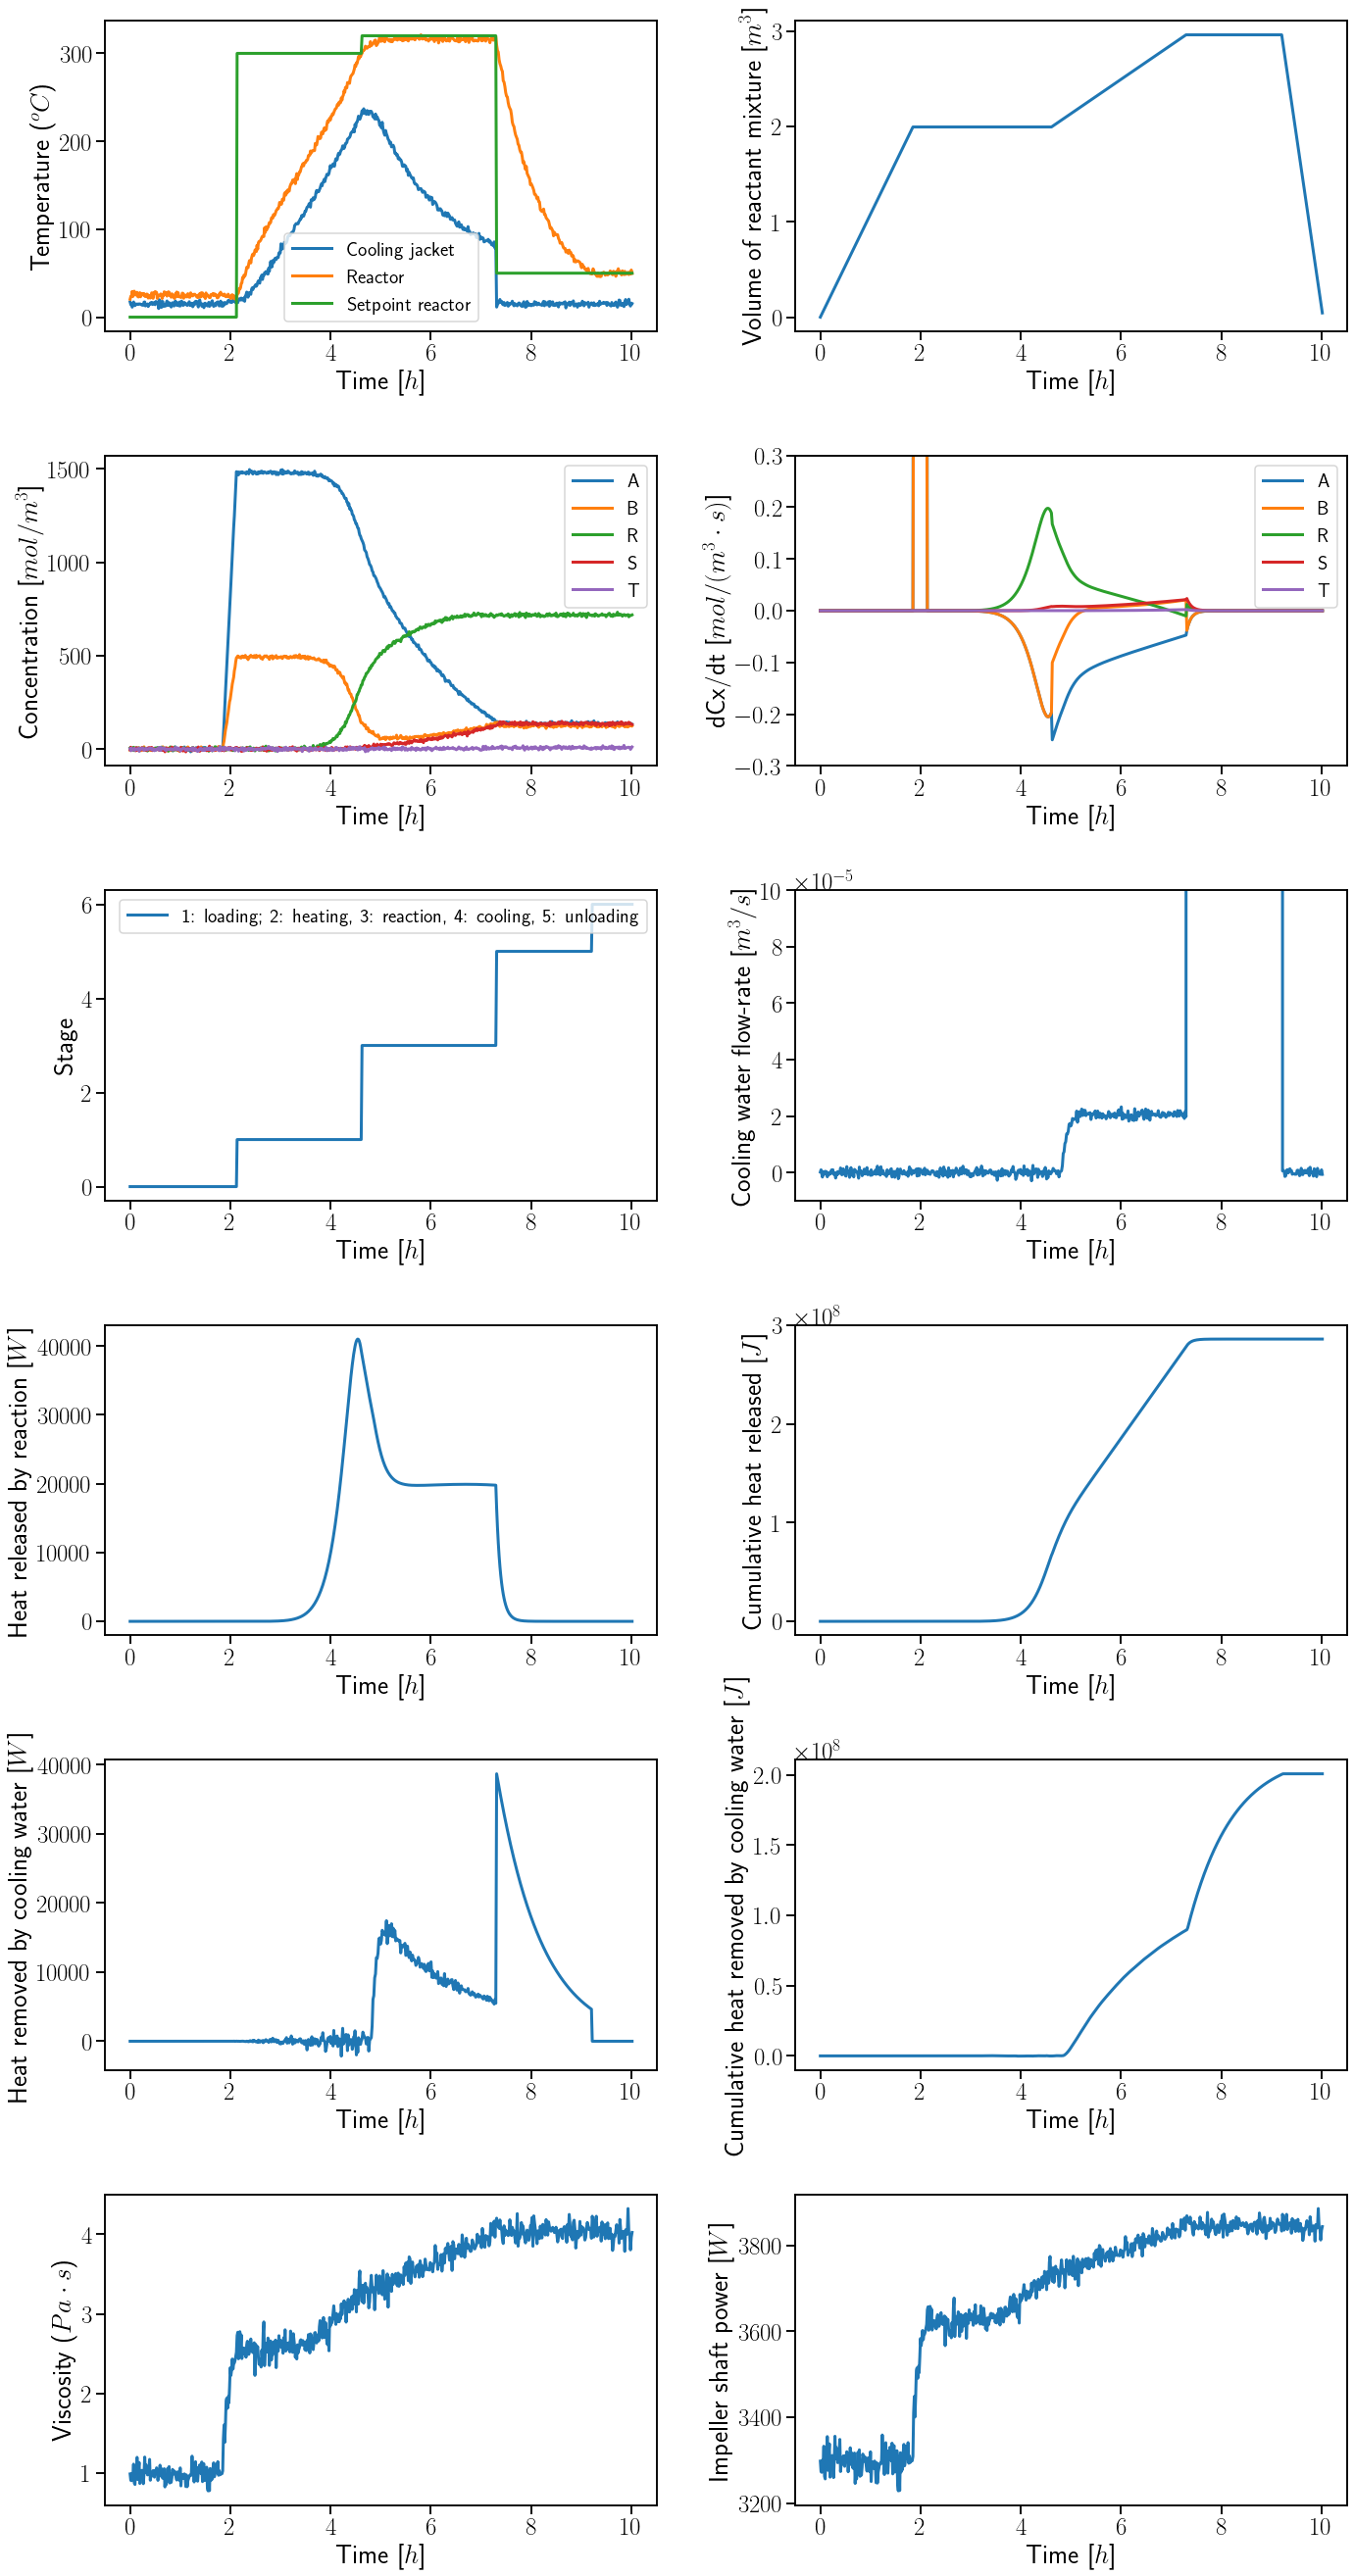

In [11]:
def PlotReactor(t_sim,Ca_sim,dCa_sim,Cb_sim,dCb_sim,Cr_sim,dCr_sim,Cs_sim,dCs_sim,Ct_sim,dCt_sim,mu_sim,P_impeller_sim,T_sim,Tc_sim,T_setpoint_sim,qc_sim,V_sim,cumulative_heat_released):
    fig, ax = plt.subplots(6,2,figsize=(22,44))

    # set the spacing between subplots
    fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.25,
                    hspace=0.4)

    ax[0,0].plot(t_sim/3600, Tc_sim-273, t_sim/3600, T_sim-273, t_sim/3600, T_setpoint_sim-273)
    ax[0,0].set_xlabel('Time [$h$]')
    ax[0,0].set_ylabel('Temperature ($^{o}C$)')
    ax[0,0].legend(['Cooling jacket','Reactor','Setpoint reactor'],loc='best',prop={'size': 20})

    ax[0,1].plot(t_sim/3600,V_sim)
    ax[0,1].set_xlabel('Time [$h$]')
    ax[0,1].set_ylabel('Volume of reactant mixture [$m^3$]')

    ax[1,0].plot(t_sim/3600,Ca_sim,t_sim/3600,Cb_sim,t_sim/3600,Cr_sim,t_sim/3600,Cs_sim,t_sim/3600,Ct_sim)
    ax[1,0].set_xlabel('Time [$h$]')
    ax[1,0].set_ylabel('Concentration [$mol/m^3$]')
    ax[1,0].legend(['A','B','R','S','T'],prop={'size': 20})

    ax[1,1].plot(t_sim/3600,dCa_sim,t_sim/3600,dCb_sim,t_sim/3600,dCr_sim,t_sim/3600,dCs_sim,t_sim/3600,dCt_sim)
    ax[1,1].set_xlabel('Time [$h$]')
    ax[1,1].set_ylabel('dCx/dt [$mol/(m^3 \cdot s)$]')
    ax[1,1].legend(['A','B','R','S','T'],loc='upper right',prop={'size': 20})
    ax[1,1].set_ylim(-0.3,0.3)

    ax[2,0].plot(t_sim/3600,stages_sim)
    ax[2,0].set_xlabel('Time [$h$]')
    ax[2,0].set_ylabel('Stage')
    ax[2,0].legend(['1: loading; 2: heating, 3: reaction, 4: cooling, 5: unloading'],prop={'size': 20})

    ax[2,1].plot(t_sim/3600,qc_sim)
    ax[2,1].set_xlabel('Time [$h$]')
    ax[2,1].set_ylabel('Cooling water flow-rate [$m^3/s$]')
    ax[2,1].set_ylim(-0.00001,0.0001)

    ax[3,0].plot(t_sim/3600,heat_released)
    ax[3,0].set_xlabel('Time [$h$]')
    ax[3,0].set_ylabel('Heat released by reaction [$W$]')

    ax[3,1].plot(t_sim/3600,cumulative_heat_released)
    ax[3,1].set_xlabel('Time [$h$]')
    ax[3,1].set_ylabel('Cumulative heat released [$J$]')

    ax[4,0].plot(t_sim/3600,heat_removed)
    ax[4,0].set_xlabel('Time [$h$]')
    ax[4,0].set_ylabel('Heat removed by cooling water [$W$]')

    ax[4,1].plot(t_sim/3600,cumulative_heat_removed)
    ax[4,1].set_xlabel('Time [$h$]')
    ax[4,1].set_ylabel('Cumulative heat removed by cooling water [$J$]')

    ax[5,0].plot(t_sim/3600,mu_sim)
    ax[5,0].set_xlabel('Time [$h$]')
    ax[5,0].set_ylabel('Viscosity ($Pa \cdot s$)')

    ax[5,1].plot(t_sim/3600,P_impeller_sim)
    ax[5,1].set_xlabel('Time [$h$]')
    ax[5,1].set_ylabel('Impeller shaft power [$W$]')

    plt.show()

PlotReactor(t_sim,Ca_sim_noise,dCa_sim,Cb_sim_noise,dCb_sim,Cr_sim_noise,dCr_sim,Cs_sim_noise,dCs_sim,Ct_sim_noise,dCt_sim,mu_sim,P_impeller_sim,T_sim_noise,Tc_sim_noise,T_setpoint_sim,qc_sim,V_sim,cumulative_heat_released)